# Full Project: Amsterdam House Price Prediction
This project demonstrates a full pipeline from loading data, EDA, feature engineering, to training a model to predict house prices based on the dataset available at

Data source -> https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction

## Creation of the requirements.txt file

In [1]:
#pip freeze > requirements.txt

# Import / Data load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Randomize seed for creation of different models
np.random.seed(42)

In [4]:
# Load the data
df = pd.read_csv('HousingPrices-Amsterdam-August-2021.csv')
df.head()

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


# Data exploration

In [5]:
# Basic EDA
print(df.info())
print('\nMissing values per column:')
print(df.isnull().sum())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  924 non-null    int64  
 1   Address     924 non-null    object 
 2   Zip         924 non-null    object 
 3   Price       920 non-null    float64
 4   Area        924 non-null    int64  
 5   Room        924 non-null    int64  
 6   Lon         924 non-null    float64
 7   Lat         924 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 57.9+ KB
None

Missing values per column:
Unnamed: 0    0
Address       0
Zip           0
Price         4
Area          0
Room          0
Lon           0
Lat           0
dtype: int64


,Unnamed: 0,Price,Area,Room,Lon,Lat
count,924.000000,9.200000e+02,924.000000,924.000000,924.000000,924.000000
mean,462.500000,6.220654e+05,95.952381,3.571429,4.888605,52.363326
std,266.880123,5.389942e+05,57.447436,1.592332,0.053140,0.024028
min,1.000000,1.750000e+05,21.000000,1.000000,4.644819,52.291519
25%,231.750000,3.500000e+05,60.750000,3.000000,4.855834,52.352077
50%,462.500000,4.670000e+05,83.000000,3.000000,4.886818,52.364631
75%,693.250000,7.000000e+05,113.000000,4.000000,4.922337,52.377598
max,924.000000,5.950000e+06,623.000000,14.000000,5.029122,52.423805


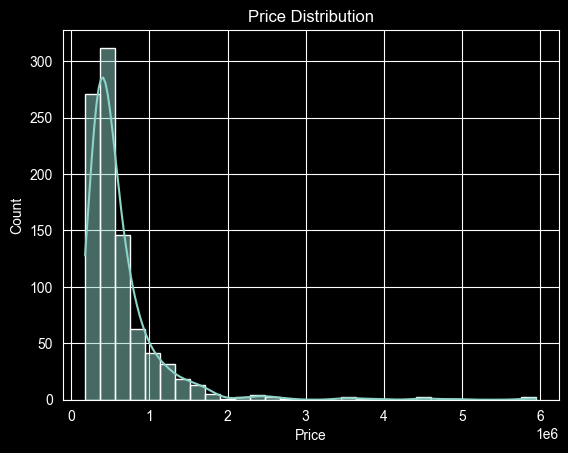

In [6]:
# Price distribution
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.show()

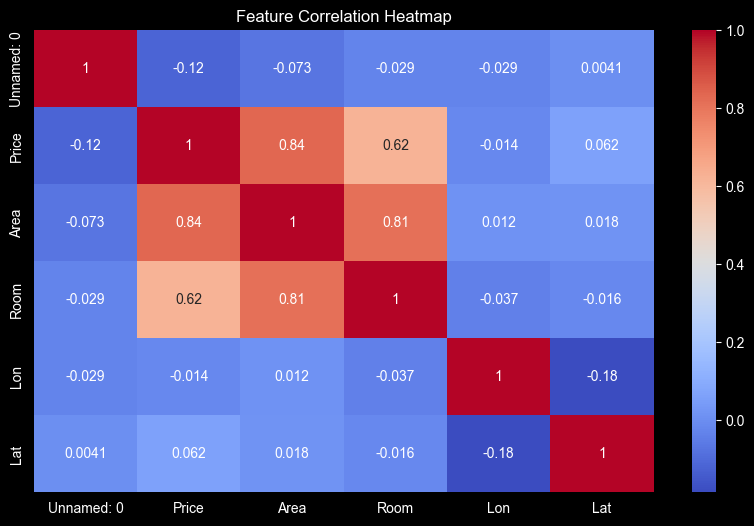

In [7]:
# Correlation heatmap for numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Feature Engineering

In [8]:
# Drop address, assume Zip and Type are important
df = df.dropna()
X = df.drop(['Price', 'Address'], axis=1)
y = df['Price']

In [9]:
# Preprocessing pipeline
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Model Creation / Training

In [10]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Model pipeline and training
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42))
])

model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
# Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 93872.82
RMSE: 219768.63
R² Score: 0.84


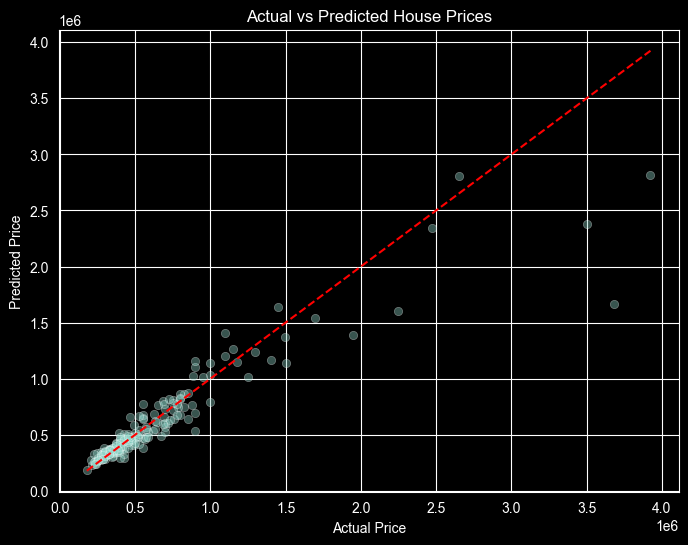

In [13]:
# Prediction visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted House Prices')
plt.grid(True)
plt.show()

## Model Saving

In [14]:
# Save trained model
joblib.dump(model, 'model.pkl')

['amsterdam_house_price_model.pkl']